In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Oct 19 04:18:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import os
import cv2
import skimage.io as io
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models,layers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Conv2D,
    Dense,
    DepthwiseConv2D,
    Dropout,
    GlobalAveragePooling2D,
    Input,
    PReLU,
    Reshape,
    Multiply,
)

In [4]:
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 0.001
CONV_KERNEL_INITIALIZER = keras.initializers.VarianceScaling(scale=2.0, mode="fan_out", distribution="truncated_normal")
# CONV_KERNEL_INITIALIZER = 'glorot_uniform'

BLOCK_CONFIGS = {
    "b0": {
        "first_conv_filter": 32,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 48, 96, 112, 192],
        "depthes": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b1": {
        "first_conv_filter": 32,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 48, 96, 112, 192],
        "depthes": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b2": {
        "first_conv_filter": 32,
        "output_conv_filter": 1408,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 56, 104, 120, 208],
        "depthes": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b3": {
        "first_conv_filter": 40,
        "output_conv_filter": 1536,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 40, 56, 112, 136, 232],
        "depthes": [2, 3, 3, 5, 7, 12],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "s": {
        "first_conv_filter": 24,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [24, 48, 64, 128, 160, 256],
        "depthes": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "m": {
        "first_conv_filter": 24,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6, 6],
        "out_channels": [24, 48, 80, 160, 176, 304, 512],
        "depthes": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "use_ses": [0, 0, 0, 1, 1, 1, 1],
    },
    "l": {
        "first_conv_filter": 32,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6, 6],
        "out_channels": [32, 64, 96, 192, 224, 384, 640],
        "depthes": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "use_ses": [0, 0, 0, 1, 1, 1, 1],
    },
}
def _make_divisible(v, divisor=4, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def conv2d_no_bias(inputs, filters, kernel_size, strides=1, padding="VALID"):
    return Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER
    )(inputs)


def batchnorm_with_activation(inputs, activation="swish"):
    """Performs a batch normalization followed by an activation. """
    bn_axis = 1 if K.image_data_format() == "channels_first" else -1
    nn = BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
    )(inputs)
    if activation:
        nn = Activation(activation=activation)(nn)
        # nn = PReLU(shared_axes=[1, 2], alpha_initializer=tf.initializers.Constant(0.25))(nn)
    return nn


def se_module(inputs, se_ratio=4):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    h_axis, w_axis = [2, 3] if K.image_data_format() == "channels_first" else [1, 2]

    filters = inputs.shape[channel_axis]
    # reduction = _make_divisible(filters // se_ratio, 8)
    reduction = filters // se_ratio
    # se = GlobalAveragePooling2D()(inputs)
    # se = Reshape((1, 1, filters))(se)
    se = tf.reduce_mean(inputs, [h_axis, w_axis], keepdims=True)
    se = Conv2D(reduction, kernel_size=1, use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER)(se)
    # se = PReLU(shared_axes=[1, 2])(se)
    se = Activation("swish")(se)
    se = Conv2D(filters, kernel_size=1, use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER)(se)
    se = Activation("sigmoid")(se)
    return Multiply()([inputs, se])


def MBConv(inputs, output_channel, stride, expand_ratio, shortcut, survival=None, use_se=0, is_fused=False):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    input_channel = inputs.shape[channel_axis]

    if is_fused and expand_ratio != 1:
        nn = conv2d_no_bias(inputs, input_channel * expand_ratio, (3, 3), strides=stride, padding="same")
        nn = batchnorm_with_activation(nn)
    elif expand_ratio != 1:
        nn = conv2d_no_bias(inputs, input_channel * expand_ratio, (1, 1), strides=(1, 1), padding="same")
        nn = batchnorm_with_activation(nn)
    else:
        nn = inputs

    if not is_fused:
        nn = DepthwiseConv2D(
            (3, 3), padding="same", strides=stride, use_bias=False, depthwise_initializer=CONV_KERNEL_INITIALIZER
        )(nn)
        nn = batchnorm_with_activation(nn)

    if use_se:
        nn = se_module(nn, se_ratio=4 * expand_ratio)

    # pw-linear
    if is_fused and expand_ratio == 1:
        nn = conv2d_no_bias(nn, output_channel, (3, 3), strides=stride, padding="same")
        nn = batchnorm_with_activation(nn)
    else:
        nn = conv2d_no_bias(nn, output_channel, (1, 1), strides=(1, 1), padding="same")
        nn = batchnorm_with_activation(nn, activation=None)

    if shortcut:
        if survival is not None and survival < 1:
            from tensorflow_addons.layers import StochasticDepth

            return StochasticDepth(float(survival))([inputs, nn])
        else:
            return Add()([inputs, nn])
    else:
        return nn
def EfficientNetV2(
    model_type,
    input_shape,
    classes,
    dropout,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    name="EfficientNetV2",
    ):
    """
    model_type: is the pre-defined model, value in ["s", "m", "l", "b0", "b1", "b2", "b3"].
    first_strides: is used in the first Conv2D layer.
    survivals: is used for [Deep Networks with Stochastic Depth](https://arxiv.org/abs/1603.09382).
        Can be a constant value like `0.5` or `0.8`,
        or a tuple value like `(1, 0.8)` indicates the survival probability linearly changes from `1 --> 0.8` for `top --> bottom` layers.
        A higher value means a higher probability will keep the conv branch.
        or `None` to disable.
    """
    blocks_config = BLOCK_CONFIGS.get(model_type.lower(), BLOCK_CONFIGS[model_type])
    expands = blocks_config["expands"]
    out_channels = blocks_config["out_channels"]
    depthes = blocks_config["depthes"]
    strides = blocks_config["strides"]
    use_ses = blocks_config["use_ses"]
    first_conv_filter = blocks_config.get("first_conv_filter", out_channels[0])
    output_conv_filter = blocks_config.get("output_conv_filter", 1280)

    inputs = Input(shape=input_shape)
    out_channel = _make_divisible(first_conv_filter, 8)
    nn = conv2d_no_bias(inputs, out_channel, (3, 3), strides=first_strides, padding="same")
    nn = batchnorm_with_activation(nn)

    # StochasticDepth survival_probability values
    total_layers = sum(depthes)
    if isinstance(survivals, float):
        survivals = [survivals] * total_layers
    elif isinstance(survivals, (list, tuple)) and len(survivals) == 2:
        start, end = survivals
        survivals = [start - (1 - end) * float(ii) / total_layers for ii in range(total_layers)]
    else:
        survivals = [None] * total_layers
    survivals = [survivals[int(sum(depthes[:id])) : sum(depthes[: id + 1])] for id in range(len(depthes))]

    pre_out = out_channel
    for expand, out_channel, depth, survival, stride, se in zip(expands, out_channels, depthes, survivals, strides, use_ses):
        out = _make_divisible(out_channel, 8)
        is_fused = True if se == 0 else False
        for ii in range(depth):
            stride = stride if ii == 0 else 1
            shortcut = True if out == pre_out and stride == 1 else False
            nn = MBConv(nn, out, stride, expand, shortcut, survival[ii], se, is_fused)
            pre_out = out

    output_conv_filter = _make_divisible(output_conv_filter, 8)
    nn = conv2d_no_bias(nn, output_conv_filter, (1, 1), strides=(1, 1), padding="valid")
    nn = batchnorm_with_activation(nn)

    if classes > 0:
        nn = GlobalAveragePooling2D(name="avg_pool")(nn)
        if dropout > 0 and dropout < 1:
            nn = Dropout(dropout)(nn)
        nn = Dense(classes, activation=classifier_activation, name="predictions")(nn)
    return Model(inputs=inputs, outputs=nn, name=name)

In [5]:
TRAIN_SIZE = 240
VAL_SIZE = 300
BATCH_SIZE = 64
VALIDATION_SPLIT = 0
EPOCHS = 100

In [13]:
model = EfficientNetV2(
    model_type="b3",
    input_shape=(TRAIN_SIZE, TRAIN_SIZE, 3),
    classes=10,
    dropout=0.3,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    name="EfficientNetV2",
)
model.summary()

Model: "EfficientNetV2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 120, 120, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 120, 120, 40) 160         conv2d_112[0][0]                 
__________________________________________________________________________________________________
activation_106 (Activation)     (None, 120, 120, 40) 0           batch_normalization_88[0][0]     
_____________________________________________________________________________________

In [7]:
!git clone https://github.com/tranduchuy682/NICS_DATA.git
# !gdown https://drive.google.com/u/2/uc?id=1-5dmQNnb0fqJ5qtzDGek665xSLCODv0w  #aff
# !gdown https://drive.google.com/u/2/uc?id=1-1T1TLEZbdV-OV78m1Nodx34As5w8I4I  #aff

Cloning into 'NICS_DATA'...
remote: Enumerating objects: 3701, done.
remote: Total 3701 (delta 0), reused 0 (delta 0), pack-reused 3701
Receiving objects: 100% (3701/3701), 409.88 MiB | 25.21 MiB/s, done.
Checking out files: 100% (3700/3700), done.


In [8]:
folder_path="/content/NICS_DATA/data_NICS"
class_names = ['1 Hầu họng', '2 Thực quản', '3 Tâm vị', '4 Thân vị','5 Phình vị',
               '6 Hang vị','7 Bờ cong lớn','8 Bờ cong nhỏ','9 Hành tá tràng','10 Tá tràng']
num_classes = len(class_names)

encode = OneHotEncoder()

def loadimage(dataset):
    images = []
    labels = []
    count = 0
    for i in range(num_classes):
        label = i
        fold = f'{folder_path}/{dataset}/{class_names[i]}'
        for file in tqdm(os.listdir(fold)):
            img_path = os.path.join(fold, file)
            image = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
            # image = cv2.cvtColor(image, cv2.COLOR_2RGB)
            # image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
            image = cv2.resize(image, (TRAIN_SIZE,TRAIN_SIZE))
            # if dataset == 'train':
            #     image = cv2.resize(image, (TRAIN_SIZE,TRAIN_SIZE))
            # elif dataset == 'test':
            #     image = cv2.resize(image, (VAL_SIZE,VAL_SIZE))
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'int32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels
train_images, train_labels = loadimage('train')
test_images, test_labels = loadimage('test')
# import pickle

# def _load_pkl(path):
#   with open(path, 'rb') as f:
#     obj = pickle.load(f)
#   return obj

# # # Load lại dữ liệu
# train_images = _load_pkl('./aff_images')
# train_labels = _load_pkl('./aff_labels')

# one hot encode
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(len(train_images))
print(len(test_images))

100%|██████████| 74/74 [00:01<00:00, 70.45it/s]


2960
740


In [9]:
print(test_images.shape)

(740, 240, 240, 3)


In [12]:
print(train_labels)
print(test_labels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [10]:
#Normalization
train_images = train_images / 255.0 
# val_images = val_images / 255.0
test_images = test_images / 255.0
# def LabelSmoothing(labels):
#     factor = 0.1
#     labels *= (1 - factor)
#     labels += factor / labels.shape[1]
#     return labels
# train_labels = LabelSmoothing(train_labels)
# print(train_labels)

In [14]:
def scheduler(epoch, lr):
    if epoch < 3 : return float(lr)
    else: return lr * (1.0 - epoch / 90)
callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
callback3 = tf.keras.callbacks.ModelCheckpoint(
                            filepath="/content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-v2-b3.h5",
                            save_weights_only=True,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True,
                            verbose=1)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate=1e-3,
                            decay_steps=10000,
                            decay_rate=0.97,
                            staircase = True)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=0.001, decay_steps=100, alpha=1e-7, name=None
# )
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, rho=0.9, momentum=0.9, epsilon=1e-07)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.97)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics='accuracy')

In [15]:
history = model.fit(
    train_images, 
    train_labels, 
    batch_size =32 , 
    epochs = EPOCHS, 
    # validation_split = 0.1,
    validation_data=(test_images, test_labels), 
    callbacks=[callback3]
    )

Epoch 1/100
93/93 [==============================] - 50s 254ms/step - loss: 1.3647 - accuracy: 0.5307 - val_loss: 0.9829 - val_accuracy: 0.6892

Epoch 00001: val_accuracy improved from -inf to 0.68919, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-v2-b3.h5
Epoch 2/100
93/93 [==============================] - 21s 226ms/step - loss: 0.5620 - accuracy: 0.8027 - val_loss: 0.7270 - val_accuracy: 0.7622

Epoch 00002: val_accuracy improved from 0.68919 to 0.76216, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-v2-b3.h5
Epoch 3/100
93/93 [==============================] - 21s 226ms/step - loss: 0.3502 - accuracy: 0.8818 - val_loss: 0.6916 - val_accuracy: 0.7824

Epoch 00003: val_accuracy improved from 0.76216 to 0.78243, saving model to /content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-v2-b3.h5
Epoch 4/100
93/93 [==============================] - 21s 227ms/step - loss: 0.2902

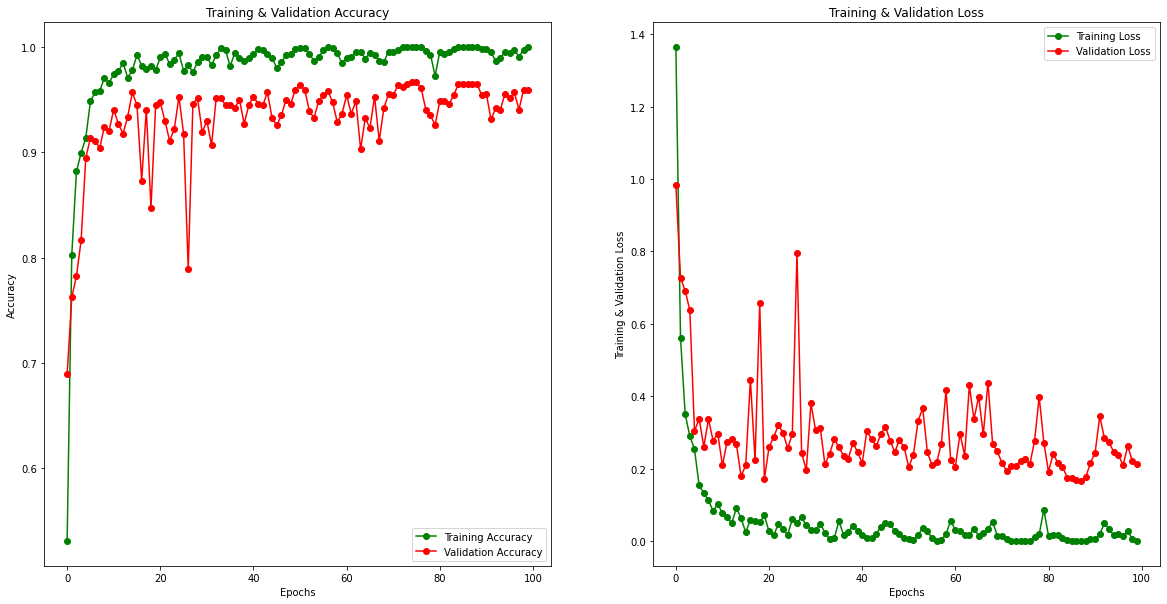

In [16]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
plot_accuracy_loss_chart(history)

In [17]:
model.load_weights("/content/drive/MyDrive/COLAB/Segmentation of Endoscopic Image/Data/efficient-v2-b3.h5")

In [18]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
# print(predictions)
print(classification_report(
    np.argmax(test_labels, axis=1), 
    predictions, 
    target_names = class_names))

                 precision    recall  f1-score   support

     1 Hầu họng       1.00      1.00      1.00        74
    2 Thực quản       1.00      1.00      1.00        74
       3 Tâm vị       1.00      1.00      1.00        74
      4 Thân vị       0.88      0.89      0.89        74
     5 Phình vị       0.96      0.92      0.94        74
      6 Hang vị       0.99      0.95      0.97        74
  7 Bờ cong lớn       0.89      0.97      0.93        74
  8 Bờ cong nhỏ       0.97      0.96      0.97        74
9 Hành tá tràng       1.00      0.99      0.99        74
    10 Tá tràng       0.99      0.99      0.99        74

       accuracy                           0.97       740
      macro avg       0.97      0.97      0.97       740
   weighted avg       0.97      0.97      0.97       740



In [22]:
print(predictions)
print(np.argmax(test_labels,axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 5 3 3 3 6 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7 3 3 3 3 3 3 3 6 3 3 3 3 3 6 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 6 4 4 4 4 3 4 4 4 3
 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 3 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 3 6 

In [26]:
print(confusion_matrix(np.argmax(test_labels,axis=1), predictions))

[[74  0  0  0  0  0  0  0  0  0]
 [ 0 74  0  0  0  0  0  0  0  0]
 [ 0  0 74  0  0  0  0  0  0  0]
 [ 0  0  0 66  0  1  6  1  0  0]
 [ 0  0  0  5 68  0  1  0  0  0]
 [ 0  0  0  2  1 70  0  1  0  0]
 [ 0  0  0  2  0  0 72  0  0  0]
 [ 0  0  0  0  2  0  1 71  0  0]
 [ 0  0  0  0  0  0  0  0 73  1]
 [ 0  0  0  0  0  0  1  0  0 73]]


In [24]:
tn, fp, fn, tp = confusion_matrix(np.argmax(test_labels,axis=1), predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Spectivity on testing data: {:.5f}%".format(100*specificity))
print("Sensitivy on testing data: {:.5f}%".format(100*sensitivity))

ValueError: ignored